In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 21:06:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [5]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from pyspark.sql import functions as F


warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data/Transactions Data'

In [6]:
with open("/kaggle/input/transactions-data-big-data/mcc_codes.json", "r") as f:
    mcc_dict = json.load(f)

# Convert to list of dicts
mcc_list = [{"mcc": int(k), "description": v} for k, v in mcc_dict.items()]
mcc_df = spark.createDataFrame(mcc_list)
mcc_df.printSchema()

root
 |-- description: string (nullable = true)
 |-- mcc: long (nullable = true)



In [7]:
# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [8]:
# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

transactions_df = transactions_df.join(mcc_df, on="mcc", how="left")

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963


+----+-------+-------------------+---------+-------+------+-----------------+-----------+-------------+--------+------+--------------------+
| mcc|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|merchant_city|  errors|target|         description|
+----+-------+-------------------+---------+-------+------+-----------------+-----------+-------------+--------+------+--------------------+
|3780|7475460|2010-01-01 03:08:00|      957|   4532|-147.0|Swipe Transaction|      44795|   Marysville|No Error|    No|Computer Network ...|
|4121|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33|Swipe Transaction|      33326|      Kahului|No Error|    No|Taxicabs and Limo...|
|4121|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14|Swipe Transaction|      29232|       Osprey|No Error|    No|Taxicabs and Limo...|
+----+-------+-------------------+---------+-------+------+-----------------+-----------+-------------+--------+------+--------------------+
only showing 

In [9]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
print(cards_df.count())
cards_df.show(3)

4514
+---------+-------+----------+---------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+----------------+
|client_id|card_id|card_brand|card_type|     card_number|expires|cvv|has_chip|num_cards_issued|credit_limit|acct_open_date|year_pin_last_changed|card_on_dark_web|
+---------+-------+----------+---------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+----------------+
|      825|   4524|      Visa|    Debit|4344676511950444|12/2022|623|     YES|               2|     24295.0|       09/2002|                 2008|              No|
|      825|   2731|      Visa|    Debit|4956965974959986|12/2020|393|     YES|               2|     21968.0|       04/2014|                 2014|              No|
|      825|   3701|      Visa|    Debit|4582313478255491|02/2024|719|     YES|               2|     46414.0|       07/2003|                 2004|              No|
+---------+------

# Unusual Transaction Amounts per User

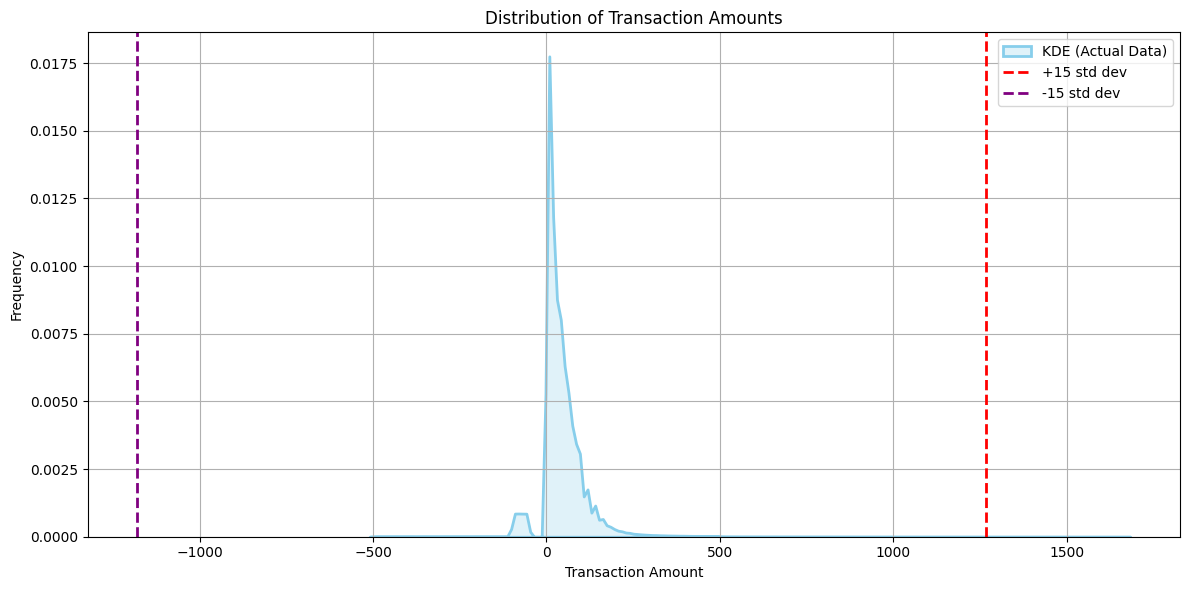

In [10]:
# Convert to Pandas
amounts_pd = transactions_df.select("amount").toPandas()

# Compute mean and std deviation
mean_amt = amounts_pd["amount"].mean()
std_amt = amounts_pd["amount"].std()


# Define clipping range
lower_bound = mean_amt - 20 * std_amt
upper_bound = mean_amt + 20 * std_amt

# Clip data to within ±20 std dev
clipped_data = amounts_pd[(amounts_pd["amount"] >= lower_bound) & (amounts_pd["amount"] <= upper_bound)]

# Plot KDE (Gaussian-like curve)
plt.figure(figsize=(12, 6))
sns.kdeplot(clipped_data["amount"], fill=True, linewidth=2, color="skyblue", label="KDE (Actual Data)")

# Plot vertical lines at ±15 * std
plt.axvline(mean_amt + 15 * std_amt, color="red", linestyle="--", linewidth=2, label="+15 std dev")
plt.axvline(mean_amt - 15 * std_amt, color="purple", linestyle="--", linewidth=2, label="-15 std dev")

# Labels and legend
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Get avg and std of amount per user
user_amt_stats = transactions_df.groupBy("client_id").agg(
    F.avg("amount").alias("avg_amt"),
    F.stddev("amount").alias("std_amt")
)

# Join back to the transactions to compare each transaction
txn_with_stats_df = transactions_df.join(user_amt_stats, on="client_id")

# Flag if amount > avg + 3 * std (could tweak threshold)
unusual_txns  = txn_with_stats_df.filter(col("amount") > col("avg_amt") + 15 * col("std_amt"))

unusual_pd = unusual_txns.toPandas()
unusual_txns.select("client_id", "amount", "avg_amt", "std_amt", "merchant_id").show()

+---------+-------+------------------+------------------+-----------+
|client_id| amount|           avg_amt|           std_amt|merchant_id|
+---------+-------+------------------+------------------+-----------+
|     1591|1004.46| 28.58476908383928|58.414128384934195|      13348|
|     1591|1051.73| 28.58476908383928|58.414128384934195|      38489|
|     1591| 955.75| 28.58476908383928|58.414128384934195|      60152|
|     1127|1567.11| 33.06004265119847| 56.92424918384133|       9026|
|      737|1448.74|41.833427748439746| 65.53010772623821|      38489|
|      737|1050.86|41.833427748439746| 65.53010772623821|      68977|
|     1303| 2704.6| 77.79286181818179|144.24754976837139|      47225|
|     1903|1509.89|42.037353107664416| 92.64308080480127|       5594|
|       53|1137.26|30.349789578534512| 68.84238364181466|      94532|
|       53|1176.38|30.349789578534512| 68.84238364181466|      85600|
|      472|1566.05|29.758960920933053| 79.74243099715697|      22792|
|     1718| 874.49| 

In [12]:
unusual_pd.columns

Index(['client_id', 'mcc', 'id', 'date', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'errors', 'target', 'description',
       'avg_amt', 'std_amt'],
      dtype='object')

In [13]:
# Select only the needed columns from unusual_txns before join
total_spent_per_user = unusual_txns.select("client_id", "avg_amt")


total_spent_per_user.printSchema()

users_with_spent = users_df.join(total_spent_per_user, on="client_id", how="inner")

total_credit_limit_per_user = cards_df.groupBy("client_id").agg(
    F.avg("credit_limit").alias("avg_credit_limit")
)

# Step 2: Join the result with total_credit_limit_per_user
users_with_spent_and_credit = users_with_spent.join(total_credit_limit_per_user, on="client_id", how="inner")

users_with_spent_and_credit.count()
users_with_spent_and_credit_pd = users_with_spent_and_credit.select(
    "current_age", "avg_credit_limit", "avg_amt", "yearly_income"
).toPandas()

root
 |-- client_id: integer (nullable = true)
 |-- avg_amt: double (nullable = true)



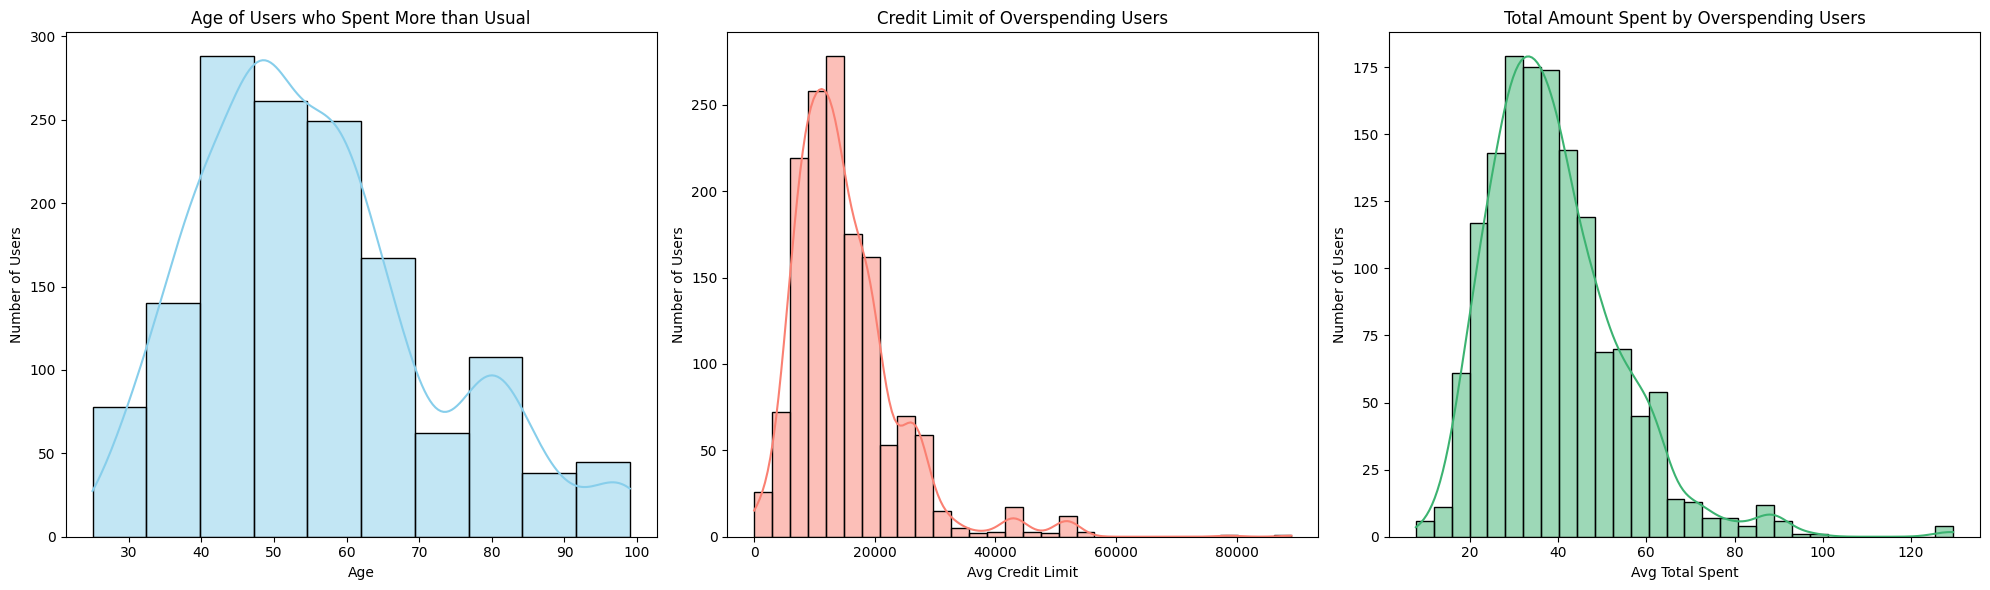

In [14]:
# Set figure size and layout
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# Histogram 1: Age
sns.histplot(data=users_with_spent_and_credit_pd, x="current_age", bins=10, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title("Age of Users who Spent More than Usual")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Number of Users")

# Histogram 2: Credit Limit
sns.histplot(data=users_with_spent_and_credit_pd, x="avg_credit_limit", bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title("Credit Limit of Overspending Users")
axes[1].set_xlabel("Avg Credit Limit")
axes[1].set_ylabel("Number of Users")

# Histogram 3: Total Spent
sns.histplot(data=users_with_spent_and_credit_pd, x="avg_amt", bins=30, kde=True, color='mediumseagreen', ax=axes[2])
axes[2].set_title("Total Amount Spent by Overspending Users")
axes[2].set_xlabel("Avg Total Spent")
axes[2].set_ylabel("Number of Users")

# Adjust layout
plt.tight_layout()
plt.show()

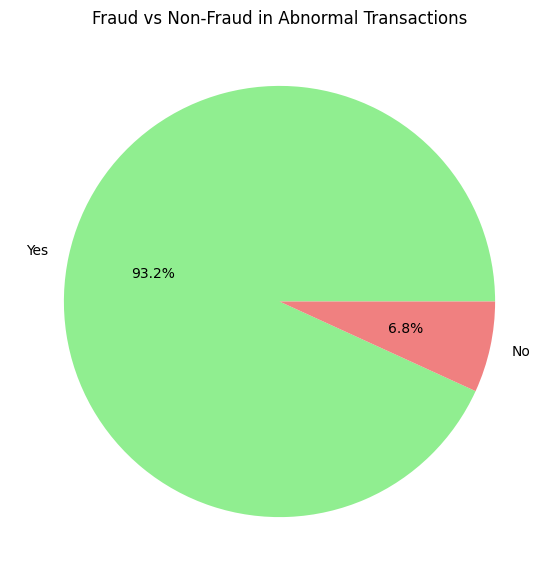

In [15]:
# Get the percentage of fraud and non-fraud transactions
fraud_counts = unusual_pd["target"].value_counts()
# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(fraud_counts, labels=["Yes", "No"], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title("Fraud vs Non-Fraud in Abnormal Transactions")
plt.show()

# Uncommon Merchant Interaction Patterns

In [16]:
# Count number of times each user interacted with each merchant
user_merchant_counts = transactions_df.groupBy("client_id", "merchant_id").count()

# Get merchants each user commonly interacts with (e.g., more than 2 times)
common_merchants = user_merchant_counts.filter(F.col("count") > 2)

common_merchants.show

<bound method DataFrame.show of DataFrame[client_id: int, merchant_id: int, count: bigint]>

In [17]:
# Mark whether a transaction is from a common merchant
txn_with_merchants = transactions_df.join(
    common_merchants.select("client_id", "merchant_id").withColumn("is_common", F.lit(1)),
    on=["client_id", "merchant_id"],
    how="left"
).fillna({"is_common": 0})


# Join back to the transactions to compare each transaction
merchants_txns_fullinfo = txn_with_merchants.join(user_amt_stats, on="client_id")

merchants_txns_fullinfo.printSchema()

uncommon_merchants_txns = merchants_txns_fullinfo.filter(F.col("is_common") == 0)

uncommon_merchants_txns.printSchema()

root
 |-- client_id: integer (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- errors: string (nullable = true)
 |-- target: string (nullable = true)
 |-- description: string (nullable = true)
 |-- is_common: integer (nullable = false)
 |-- avg_amt: double (nullable = true)
 |-- std_amt: double (nullable = true)

root
 |-- client_id: integer (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- errors: string (nullable =

In [18]:
uncommon_large_txns = uncommon_merchants_txns.filter(F.col("amount") > F.col("avg_amt") + 15 * F.col("std_amt"))  
uncommon_large_txns_pd = uncommon_large_txns.toPandas()
uncommon_large_txns.count()

891

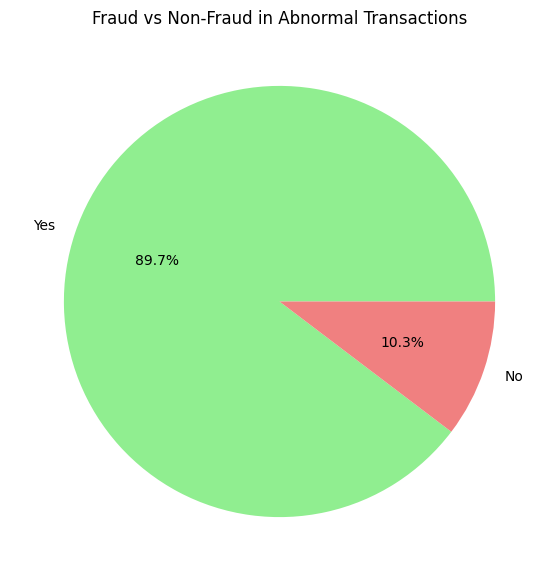

In [19]:
# Get the percentage of fraud and non-fraud transactions
fraud_counts = uncommon_large_txns_pd["target"].value_counts()
# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(fraud_counts, labels=["Yes", "No"], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title("Fraud vs Non-Fraud in Abnormal Transactions")
plt.show()

### We notice that the  percentage of fraud has been increased as we specified uncommon merchants to each user :)

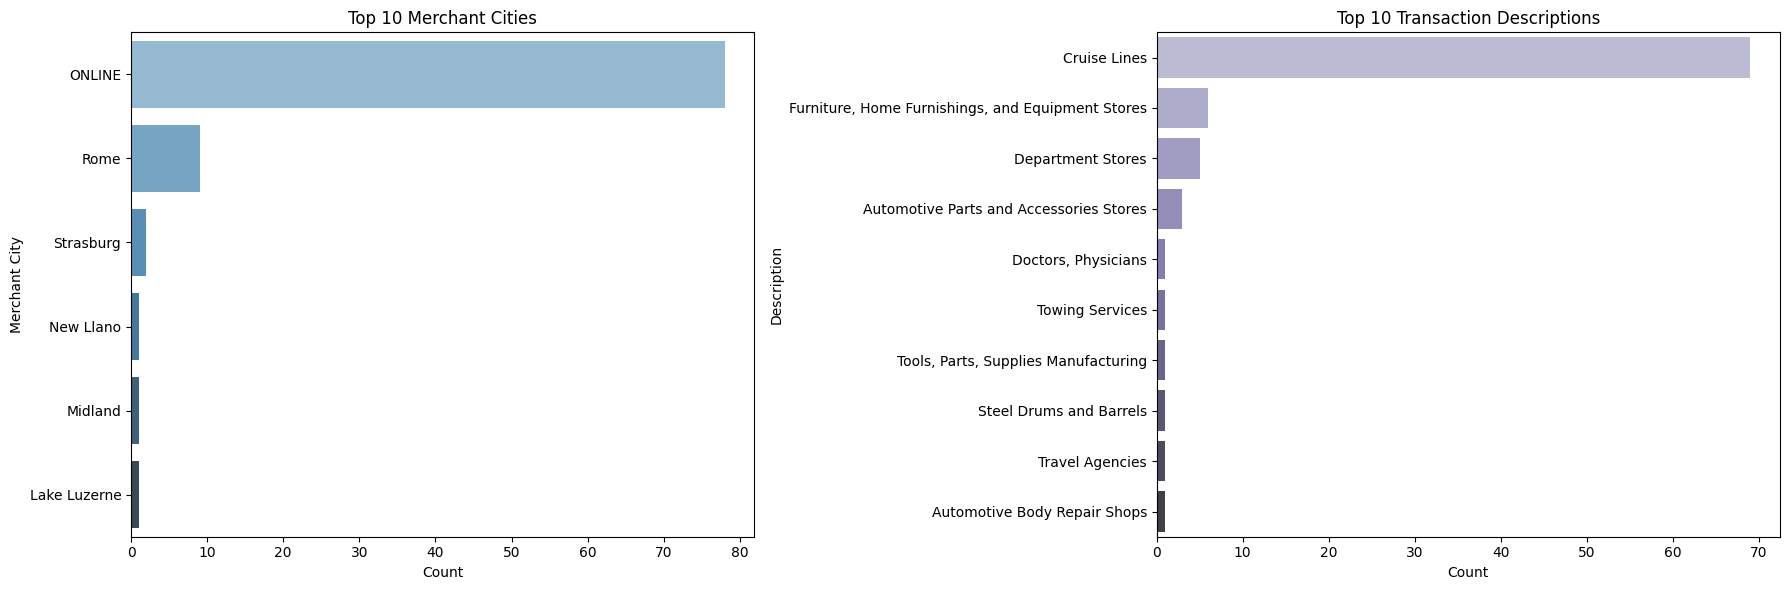

In [20]:
# Prepare data
fraud_unusual_pd = uncommon_large_txns_pd[uncommon_large_txns_pd["target"] == 'Yes']
top_cities = fraud_unusual_pd["merchant_city"].value_counts().head(10)
top_descriptions = fraud_unusual_pd["description"].value_counts().head(10)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: Merchant City
sns.barplot(x=top_cities.values, y=top_cities.index, ax=axes[0], palette="Blues_d")
axes[0].set_title("Top 10 Merchant Cities")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Merchant City")

# Right: Descriptions
sns.barplot(x=top_descriptions.values, y=top_descriptions.index, ax=axes[1], palette="Purples_d")
axes[1].set_title("Top 10 Transaction Descriptions")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Description")

plt.tight_layout()
plt.show()

### Does it make any sense for “Cruise Lines” to be the most frequent fraud description of unusual users transactions ?
   
Actually yes , If someone steals a credit card, they might use it to buy non-essential things like travel, furniture, etc. 

Cruise bookings may show up because:

* They’re hard to trace (online purchases, international companies)
* There's potential resale value (people reselling cruise tickets at discounts)


# Customer Segmentation Based on Transaction Behavior

In [21]:
# Calculate spending per user
user_spending = transactions_df.groupBy("client_id").agg(
    F.count("*").alias("num_transactions"),
    F.avg("amount").alias("avg_transaction_amount"),
    F.sum("amount").alias("total_spent"),
    F.stddev("amount").alias("std_transaction_amount")
)
user_spending.show(3)

+---------+----------------+----------------------+-----------------+----------------------+
|client_id|num_transactions|avg_transaction_amount|      total_spent|std_transaction_amount|
+---------+----------------+----------------------+-----------------+----------------------+
|     1591|           14659|     28.58476908383928|        419024.13|    58.414128384934195|
|     1959|            3451|      86.3550449145175|298011.2599999999|    163.67051516523833|
|     1238|            7366|      98.9272495248439|728698.1200000002|     148.8493821180139|
+---------+----------------+----------------------+-----------------+----------------------+
only showing top 3 rows



In [22]:
# Merge user and card features
cards_summary = cards_df.groupBy("client_id").agg(
    F.avg("credit_limit").alias("avg_credit_limit"),
    F.sum("credit_limit").alias("total_credit_limit"),
)
cards_summary.show(3)

+---------+------------------+------------------+
|client_id|  avg_credit_limit|total_credit_limit|
+---------+------------------+------------------+
|     1645|17949.666666666668|           53849.0|
|     1591|           10753.5|           64521.0|
|     1959|           11100.0|           11100.0|
+---------+------------------+------------------+
only showing top 3 rows



In [23]:
# Merge all features
features_df = users_df.join(user_spending, on="client_id", how="inner") \
                      .join(cards_summary, on="client_id", how="inner")

# Drop unused or high-cardinality columns
drop_cols = ["address", "birth_month", "birth_year","client_id","latitude","longitude","gender","any_card_on_dark_web","retirement_age","current_age"]
features_df = features_df.drop(*drop_cols)

features_df.show(1)

+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------+----------------------+----------------+------------------+
|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|num_transactions|avg_transaction_amount|total_spent|std_transaction_amount|avg_credit_limit|total_credit_limit|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------+----------------------+----------------+------------------+
|          16537.0|      33717.0|   58236.0|         698|               6|           14659|     28.58476908383928|  419024.13|    58.414128384934195|         10753.5|           64521.0|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------+----------------------+----------------+------------------+
only showing top 1 row



In [ ]:
# Assemble and scale features first
assembler = VectorAssembler(inputCols=features_df.columns, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

assembled_scaled = Pipeline(stages=[assembler, scaler]).fit(features_df).transform(features_df)

# Elbow and silhouette_score methods 
cost = []
scores = []
for k in range(2, 10):
    kmeans = KMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(assembled_scaled)
    transformed = model.transform(assembled_scaled)
    pandas_df = transformed.select("features", "cluster").toPandas()
    features = pandas_df["features"].apply(lambda x: x.toArray()).tolist()
    labels = pandas_df["cluster"]
    score = silhouette_score(features, labels)
    scores.append(score)
    cost.append(model.summary.trainingCost)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(2, 10), scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs K")
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), cost, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method to Determine Optimal K")
plt.xticks(range(2, 10))  # Force x-axis to show integer values
plt.grid(True)
plt.show()

In [ ]:
# optimal number found from the elbow graph
best_k = 4


kmeans = KMeans(k=best_k, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(assembled_scaled)
clustered_df = model.transform(assembled_scaled)

clustered_df.groupBy("cluster").agg(
    F.count("*").alias("num_users"),
    F.avg("yearly_income").alias("avg_income"),
    F.avg("total_spent").alias("avg_spending"),
    F.avg("credit_score").alias("avg_credit_score")
).orderBy("cluster").show()

In [ ]:
centers = model.clusterCenters()
centers_df = pd.DataFrame(centers, columns=features_df.columns)

# Compute standard deviation of feature values across clusters
feature_importance = centers_df.std().sort_values(ascending=False)
# Show top 3 features
top_features = feature_importance.head(5)
print("Top contributing features to cluster separation:")
print(top_features)

In [ ]:
plot_df = clustered_df.select(*features_df.columns, "cluster").toPandas()
# Create a 1x2 grid of subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Example 1: yearly_income vs avg_credit_limit
sns.scatterplot(data=plot_df, x="yearly_income", y="avg_credit_limit", hue="cluster", palette="tab10", ax=axes[0])
axes[0].set_title("Clusters based on Yearly Income vs avg_credit_limit")

# Example 2: per_capita_income vs total_credit_limit
sns.scatterplot(data=plot_df, x="per_capita_income", y="total_credit_limit", hue="cluster", palette="tab10", ax=axes[1])
axes[1].set_title("Clusters based on per_capita_income vs total_credit_limit")

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
clustered_pandas = clustered_df.select("features", "cluster").toPandas()


X = np.array([np.array(vec.toArray()) for vec in clustered_pandas["features"]])
y = clustered_pandas["cluster"]

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)


# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=60)
plt.title("t-SNE Visualization of Customer Segments")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Predicting Customer Credit Scores

In [ ]:
# Drop unused or high-cardinality columns
drop_cols = ["address", "birth_month", "birth_year","client_id","latitude","longitude","gender","any_card_on_dark_web","retirement_age","current_age","avg_credit_limit","avg_transaction_amount","std_transaction_amount"]

features_df = features_df.drop(*drop_cols)


In [ ]:
assembler = VectorAssembler(inputCols=features_df.columns, outputCol="features")


# Transform data to get 'features' column
assembled_df = assembler.transform(features_df)

# Rename the 'label' column (target for regression)
assembled_df = assembled_df.withColumnRenamed("credit_score", "label")

#  Split into training and test sets (80% train, 20% test)
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="label",regParam=0.1)
lr_model = lr.fit(train_df)

In [ ]:
training_summary = lr_model.summary

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
print("RMSE:", training_summary.rootMeanSquaredError)
print("R2:", training_summary.r2)

In [ ]:
# Predict
predictions = lr_model.transform(test_df).select("label", "prediction")

# Convert to Pandas for plotting
residuals_pd = predictions.toPandas()
residuals_pd["residual"] = residuals_pd["label"] - residuals_pd["prediction"]

In [ ]:
# Plot 1: Residuals Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=residuals_pd["prediction"], y=residuals_pd["residual"])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Credit Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

In [ ]:
# Plot 2: Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_pd["residual"], kde=True, bins=30, color='purple')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()